In [2]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression

In [3]:
f = open(r"C:\Users\alexf\OneDrive\Escritorio\alex\Data.txt", "r")
data = f.readlines()
for i in range(len(data)):
    data[i] = data[i].split('\t')
dates = [datetime.datetime.strptime(data[i][0],"%d/%m/%Y").date() for i in range(len(data))]
weights = [float(data[i][1][:-1]) for i in range(len(data))]
rates = [(weights[i+1]-weights[i])/(dates[i+1] - dates[i]).days for i in range(len(weights)-1)]
days = [(dates[i]-dates[0]).days for i in range(len(dates))]


In [4]:
def regression(X, Y, Llim, Rlim, name):
    y = np.array(Y[Llim:Rlim])
    x = np.array(X[Llim:Rlim]).reshape((-1, 1))
    new_model = LinearRegression().fit(x, y)
    print(str(name))
    print('intercept:', new_model.intercept_)
    print('slope:', new_model.coef_, '\n')
    return new_model.coef_, new_model.intercept_

In [5]:
regression_cut_2021 = regression(days, weights, 65, 130, '2021 CUT')
regression_rate_2021 = regression(days, rates, 65, 130, '2021 RATE')
regression_offseason_2021 = regression(days, weights, 140, 180, '2021 offseason')
regression_2022 = regression(days, weights, 189, -1, '2022')

2021 CUT
intercept: 98.7069874096313
slope: [-0.06571955] 

2021 RATE
intercept: -0.9952649101624407
slope: [0.00253107] 

2021 offseason
intercept: 60.2269683281217
slope: [0.0305401] 

2022
intercept: 14.75624563852061
slope: [0.10774599] 



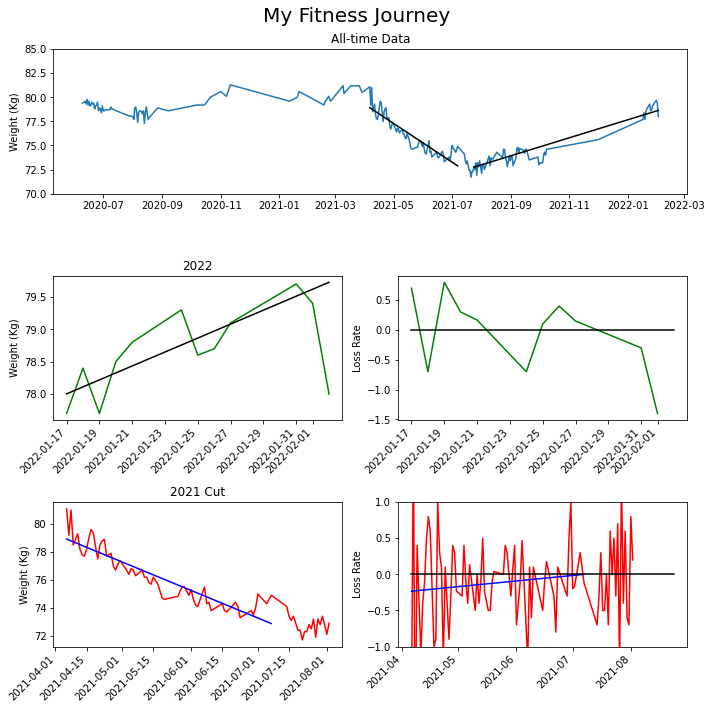

In [9]:
fig = plt.figure(figsize=(10, 10))
m, n = 65, 150
#ALL TIME DATA
ax1 = plt.subplot(311)
ax1.plot(dates,weights)
ax1.plot(dates[m:130], regression_cut_2021[0]*days[m:130] + regression_cut_2021[1] , 'k')
ax1.plot(dates[140:210], regression_offseason_2021[0]*days[140:210] + regression_offseason_2021[1], 'k')
ax1.set_title("All-time Data")
ax1.set_xlabel(" ")
ax1.set_ylabel("Weight (Kg)")
ax1.set_ylim(70,85)

#2022 CUT
l = 189
ax3 = plt.subplot(323) 
ax3.plot(dates[l:],weights[l:], 'g')
ax3.plot(dates[l:],regression_2022[0]*days[l:] + regression_2022[1], 'k')
ax3.set_title("2022")
ax3.set_ylabel("Weight (Kg)")
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')
#Rates 2022
ax5 = plt.subplot(324)
ax5.plot(dates[l:-1],rates[l:], 'g')
ax5.plot([dates[l], dates[-1]], [0,0], 'k')
ax5.set_ylabel("Loss Rate")
for label in ax5.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')

#2021 CUT
ax2 = plt.subplot(325)
ax2.plot(dates[m:n],weights[m:n], 'r')
ax2.plot(dates[m:130], days[m:130]*regression_cut_2021[0] + regression_cut_2021[1], 'b')
ax2.set_title("2021 Cut")
ax2.set_ylabel("Weight (Kg)")
for label in ax2.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')
#Rates 2021
ax4 = plt.subplot(326)
ax4.plot(dates[m:n],rates[m:n], 'r')
ax4.plot(dates[m:130], days[m:130]*regression_rate_2021[0] + regression_rate_2021[1], 'b')
ax4.plot([dates[65], dates[160]], [0,0], 'k')
ax4.set_ylim(-1,1)
ax4.set_ylabel("Loss Rate")
for label in ax4.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')    
    
fig.suptitle('My Fitness Journey', size = 20)
fig.tight_layout()